In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, accuracy_score, roc_auc_score, recall_score, f1_score
)
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [80]:
df = pd.read_csv('features_created_24h.csv')

df['shock_index_age_last'] = pd.to_numeric(df['shock_index_age_last'], errors='coerce')
df['shock_index_age_first'] = pd.to_numeric(df['shock_index_age_first'], errors='coerce')

df = df.dropna(subset=[col for col in df.columns if col != 'sepsis'], how='all')

In [82]:
df_cleaned = df.replace([np.inf, -np.inf], np.nan).fillna(-9999)

X = df_cleaned.drop(columns=['sepsis'])
y = df_cleaned['sepsis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.333333, random_state=42, stratify=y
)

In [4]:
model = XGBClassifier(
    learning_rate=0.3,
    max_depth=3,
    n_estimators=500,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    enable_categorical=True
)

In [5]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"CV Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print("AUROC: ", roc_auc)

results_df = pd.DataFrame({
        'y_true': y_test,
        'y_scores': y_proba
    })

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred, digits=4))

CV Accuracy Scores: [0.94771124 0.94716845 0.94118712 0.94589215 0.94589215]
Mean CV Accuracy: 0.9456
AUROC:  0.9311012764477893

Classification Report on Test Set:
              precision    recall  f1-score   support

           0     0.9512    0.9894    0.9699     11659
           1     0.9266    0.7255    0.8138      2157

    accuracy                         0.9482     13816
   macro avg     0.9389    0.8575    0.8919     13816
weighted avg     0.9473    0.9482    0.9455     13816



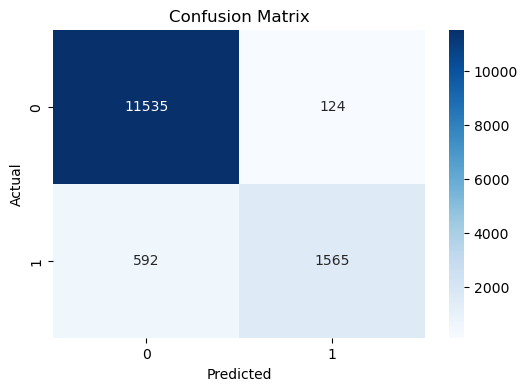

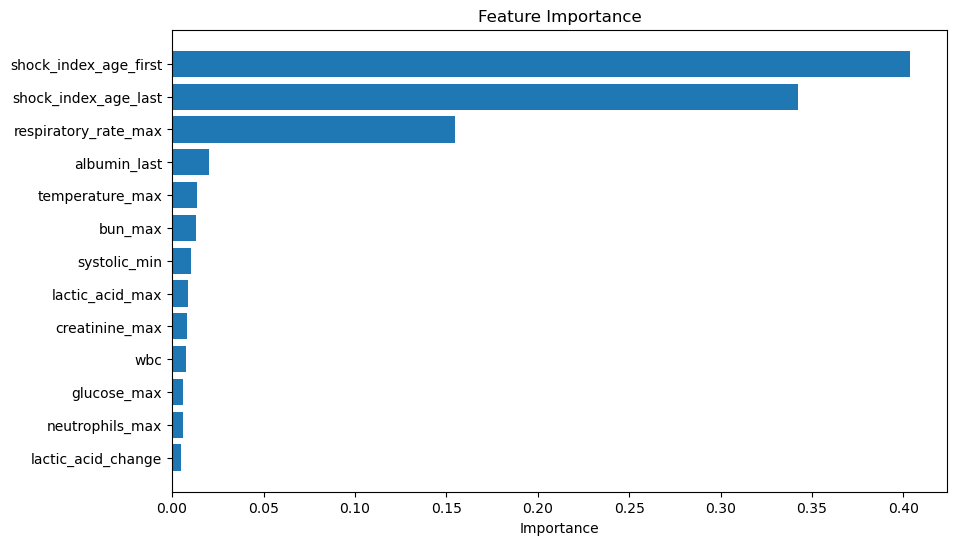

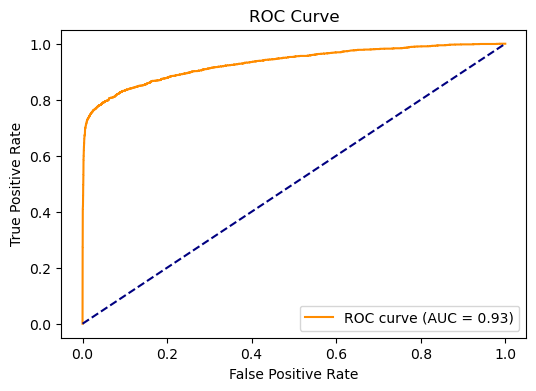

In [6]:
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(10, 6))
xgb_importances = model.feature_importances_
sorted_idx = np.argsort(xgb_importances)
plt.barh(X.columns[sorted_idx], xgb_importances[sorted_idx])
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Conformal Prediction

In [8]:
def InverseProbabilityNC(predicted_score, y):
    prob = np.zeros(y.size, dtype=np.float32)
    for i, y_ in enumerate(y):
        if y_ >= predicted_score.shape[1]:
            prob[i] = 0
        else:
            prob[i] = predicted_score[i, int(y_)]
    return 1 - prob


def compute_p_value(non_conformity_scores_train, non_conformity_scores_test):
    p_values = []
    if not isinstance(non_conformity_scores_test, list):
        non_conformity_scores_test = [non_conformity_scores_test]

    for test_point_conformity_score in non_conformity_scores_test:
        p_value = (np.sum(non_conformity_scores_train >= test_point_conformity_score) + 1) / (
            len(non_conformity_scores_train) + 1)
        p_values.append(p_value)
    return np.array(p_values)

In [9]:
from joblib import Parallel, delayed
from tqdm import tqdm
import copy

def single_prediction_set(i, X_train, y_train, X_test_row, model_base, significance_level):
    X_train_plus_test = pd.concat([X_train, pd.DataFrame(X_test_row).T])
    y_train_plus_test_0 = np.append(y_train, 0)
    y_train_plus_test_1 = np.append(y_train, 1)

    model_0 = copy.deepcopy(model_base)
    model_1 = copy.deepcopy(model_base)

    model_0.fit(X_train_plus_test, y_train_plus_test_0)
    y_pred_score_0 = model_0.predict_proba(X_train_plus_test)

    model_1.fit(X_train_plus_test, y_train_plus_test_1)
    y_pred_score_1 = model_1.predict_proba(X_train_plus_test)

    nc_0 = InverseProbabilityNC(y_pred_score_0, y_train_plus_test_0)
    nc_1 = InverseProbabilityNC(y_pred_score_1, y_train_plus_test_1)

    p_value_0 = compute_p_value(nc_0[:-1], nc_0[-1])
    p_value_1 = compute_p_value(nc_1[:-1], nc_1[-1])

    if (p_value_0 > significance_level) and (p_value_1 > significance_level):
        pred_set = [True, True]
    elif (p_value_0 > significance_level):
        pred_set = [True, False]
    elif (p_value_1 > significance_level):
        pred_set = [False, True]
    else:
        pred_set = [False, False]

    return pred_set, p_value_0, p_value_1


def prediction_sets_parallel(X_train, y_train, X_test, y_test, model=None, significance_level=0.05, n_jobs=-1):
    # Wrapper para tqdm com joblib
    class TqdmParallel(Parallel):
        def __init__(self, *args, **kwargs):
            self._tqdm = kwargs.pop("tqdm_instance", None)
            super().__init__(*args, **kwargs)

        def print_progress(self):
            if self._tqdm:
                self._tqdm.n = self.n_completed_tasks
                self._tqdm.refresh()

    tqdm_bar = tqdm(total=len(y_test), desc="Processando exemplos")

    results = TqdmParallel(n_jobs=n_jobs, tqdm_instance=tqdm_bar)(
        delayed(single_prediction_set)(i, X_train, y_train, X_test.iloc[i], model, significance_level)
        for i in range(len(y_test))
    )

    tqdm_bar.close()

    prediction_sets, p_values_class_0, p_values_class_1 = zip(*results)
    return list(prediction_sets), list(p_values_class_0), list(p_values_class_1)


In [10]:
model = XGBClassifier(
    learning_rate=0.3,
    max_depth=3,
    n_estimators=500,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

predictions_test_sets, p_values_test_set_class_0, p_values_test_set_class_1 = prediction_sets_parallel(
    X_train, y_train, X_test, y_test,
    model=model,
    significance_level=0.05,
    n_jobs=4  # usa todos os núcleos disponíveis
)

Processando exemplos: 100%|██████████| 13816/13816 [2:50:46<00:00,  1.35it/s] 


In [13]:
import pickle

with open('p_values_class_0_24h.pkl', 'wb') as f:
    pickle.dump(p_values_test_set_class_0, f)

with open('p_values_class_1_24h.pkl', 'wb') as f:
    pickle.dump(p_values_test_set_class_1, f)

In [84]:
import pickle

with open('p_values_class_0_24h.pkl', 'rb') as f:
    p_values_test_set_class_0 = pickle.load(f)

with open('p_values_class_1_24h.pkl', 'rb') as f:
    p_values_test_set_class_1 = pickle.load(f)

In [18]:
def conformal_prediction_metrics(p_values_class_0, p_values_class_1, y_test, significance_level):
    predictions_test_set = []

    for p0, p1 in zip(p_values_class_0, p_values_class_1):
        if (p0 > significance_level) and (p1 > significance_level):
            predictions_test_set.append(0 if p0 > p1 else 1)
        elif (p0 > significance_level) and (p1 <= significance_level):
            predictions_test_set.append(0)
        elif (p0 <= significance_level) and (p1 > significance_level):
            predictions_test_set.append(1)
        else:
            predictions_test_set.append(None)

    valid_indices = [i for i, pred in enumerate(predictions_test_set) if pred is not None]
    invalid_indices = [i for i, pred in enumerate(predictions_test_set) if pred is None]

    # Corrigido: usar iloc para acessar os valores pela posição
    y_test_valid = [y_test.iloc[i] for i in valid_indices]
    y_pred_valid = [predictions_test_set[i] for i in valid_indices]

    accuracy = accuracy_score(y_test_valid, y_pred_valid)
    recall = recall_score(y_test_valid, y_pred_valid)
    f1 = f1_score(y_test_valid, y_pred_valid)
    y_score = [1 - p[0] for p in p_values_test_set_class_0]  # ou p_values_class_1

    # Filtrando os mesmos índices válidos
    y_score_valid = [y_score[i] for i in valid_indices]
    
    fpr, tpr, thresholds = roc_curve(y_test_valid, y_score_valid)
    auroc = auc(fpr, tpr)

    conf_matrix = confusion_matrix(y_test_valid, y_pred_valid)
    report = classification_report(y_test_valid, y_pred_valid, digits=4)

    coverage_rate = len(valid_indices) / len(y_test)
    set_size = np.mean([
        int(p_values_class_0[i] > significance_level) + int(p_values_class_1[i] > significance_level)
        for i in range(len(y_test))
    ])

    y_test_np = y_test.to_numpy()
    removed_sepsis = np.sum(y_test_np[invalid_indices] == 1)
    removed_no_sepsis = np.sum(y_test_np[invalid_indices] == 0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUROC: {auroc:.4f}")
    print(f"Coverage Rate: {coverage_rate:.4f}")
    print(f"Set Size (avg prediction set size): {set_size:.4f}")
    print(f"Removed samples (No sepsis): {removed_no_sepsis}")
    print(f"Removed samples (Sepsis): {removed_sepsis}")
    print("\nClassification Report:")
    print(report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No sepsis', 'Sepsis'],
                yticklabels=['No sepsis', 'Sepsis'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
        'auroc': auroc,
        'coverage_rate': coverage_rate,
        'set_size': set_size,
        'removed_sepsis': removed_sepsis,
        'removed_no_sepsis': removed_no_sepsis,
        'results_df': results_df
    }

Accuracy: 0.9652
Recall: 0.7866
F1-score: 0.8647
AUROC: 0.9315
Coverage Rate: 0.8784
Set Size (avg prediction set size): 0.8793
Removed samples (No sepsis): 1238
Removed samples (Sepsis): 442

Classification Report:
              precision    recall  f1-score   support

           0     0.9659    0.9946    0.9800     10421
           1     0.9601    0.7866    0.8647      1715

    accuracy                         0.9652     12136
   macro avg     0.9630    0.8906    0.9224     12136
weighted avg     0.9651    0.9652    0.9638     12136



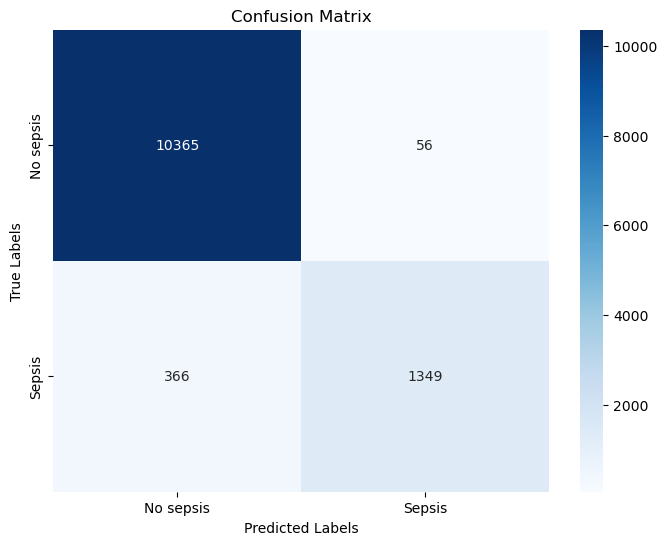

In [90]:
metrics = conformal_prediction_metrics(
    p_values_class_0=p_values_test_set_class_0,
    p_values_class_1=p_values_test_set_class_1,
    y_test=y_test,  # lista ou array com rótulos verdadeiros
    significance_level=0.15
)